# Meta data

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
meta_data = pd.read_csv(Path("data/meta_data.csv"))
name_mapping = pd.read_csv(Path("data/name_mapping.csv"))
survival_info = pd.read_csv(Path("data/survival_info.csv"))

In [4]:
meta_data.head()

,Unnamed: 0,slice_path,target,volume,slice
0,0,volume_41_slice_0.h5,0,41,0
1,1,volume_41_slice_1.h5,0,41,1
2,2,volume_41_slice_2.h5,0,41,2
3,3,volume_41_slice_3.h5,0,41,3
4,4,volume_41_slice_4.h5,0,41,4


In [5]:
name_mapping.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [6]:
survival_info.head()

,Unnamed: 0,Unnamed: 0.1,Brats20ID,Age,Survival_days,Extent_of_Resection
0,0,0,BraTS20_Training_001,60.463,289,GTR
1,1,1,BraTS20_Training_002,52.263,616,GTR
2,2,2,BraTS20_Training_003,54.301,464,GTR
3,3,3,BraTS20_Training_004,39.068,788,GTR
4,4,4,BraTS20_Training_005,68.493,465,GTR


In [7]:
survival_info.Extent_of_Resection = survival_info.Extent_of_Resection.fillna("Unknown")

In [8]:
survival_info.Extent_of_Resection.value_counts()

GTR        119
Unknown    107
STR         10
Name: Extent_of_Resection, dtype: int64

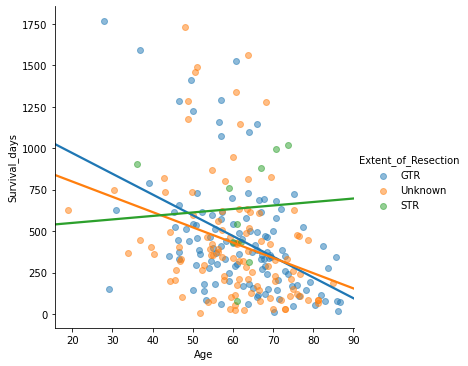

In [9]:
# gross total resection (GTR)
# subtotal resection (STR)

# Given the invariable proximity to critical neurovascular structures, 
# true complete resection of Craniopharyngiomas is challenging, and gross total resection (GTR)
# has been defined as removal of 95% of the tumor.5 Conversely, a subtotal resection (STR) 
# is intended to deliberately leave residual lesion to minimize risk of iatrogenic complication; 
# while there is no uniform residual tumor percentage cutoff to define STR, 
# some studies delineate it around 10%.

sns.lmplot(x="Age", y="Survival_days", hue="Extent_of_Resection", data=survival_info,
           truncate=False, ci=None, scatter_kws={"alpha": .5});

# Images

In [10]:
import h5py
import numpy as np
import cv2

In [11]:
def scale_to_255(img):
    img_min, img_max = np.min(img), np.max(img)
    return ((img-img_min)/img_max) * 255

In [12]:
def get_volume(idx, meta_data, data_path="data/BraTS2020_training_data"):

    df = meta_data[meta_data.volume == idx]

    for i, row in df.iterrows():
        path = Path(data_path).joinpath(row.slice_path)
        hf = h5py.File(path, "r")
        img = np.array(hf.get("image"))
        mask = np.array(hf.get("mask"))
        yield {"image": img, "mask": mask, "slice": row.slice}

In [13]:
slice_generator = get_volume(1, meta_data)

In [72]:
volume = next(slice_generator)

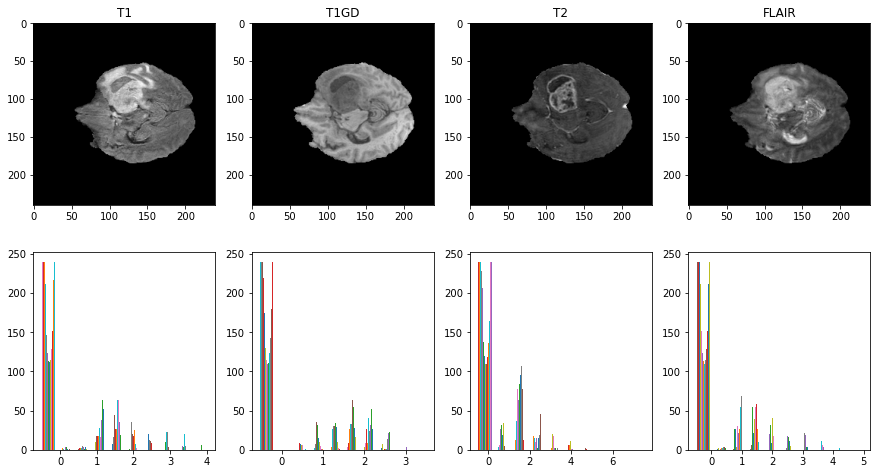

In [82]:
# a) native (T1)
# b) post-contrast T1-weighted (T1Gd)
# c) T2-weighted (T2)
# d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes

t1, t1gd, t2, flair = cv2.split(volume["image"])

fig, axs = plt.subplots(2, 4)

fig.set_size_inches(15, 8)

axs[0, 0].imshow(t1, cmap="gray")
axs[0, 0].set_title("T1")
axs[1, 0].hist(t1, bins=10)


axs[0, 1].imshow(t1gd, cmap="gray")
axs[0, 1].set_title("T1GD")
axs[1, 1].hist(t1gd, bins=10)

axs[0, 2].imshow(t2, cmap="gray")
axs[0, 2].set_title("T2")
axs[1, 2].hist(t2, bins=10)

axs[0, 3].imshow(flair, cmap="gray")
axs[0, 3].set_title("FLAIR")
axs[1, 3].hist(flair, bins=10);

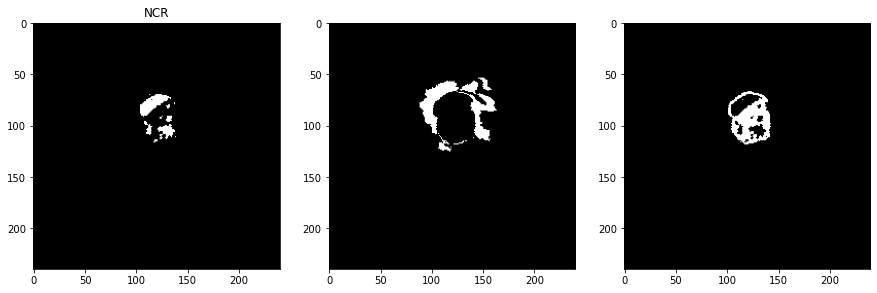

In [81]:
# necrotic and non-enhancing tumor core (NCR/NET — label 1)
# the peritumoral edema (ED — label 2) #
# the GD-enhancing tumor (ET — label 4)

ncr, ed, et = cv2.split(volume["mask"])

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 8)

axs[0].imshow(ncr, cmap="gray")
axs[0].set_title("NCR")
axs[1].imshow(ed, cmap="gray")
axs[1].set_title("ED")
axs[2].imshow(et, cmap="gray");
axs[2].set_title("ET")